# Load Claims Data and build a Fraud Prevention Model

This tutorial provides examples of how to use CSV data with TensorFlow.

There are two main parts to this:

1. **Loading the data off disk**
2. **Pre-processing it into a form suitable for training.**

This tutorial focuses on the loading, and gives some quick examples of preprocessing. To learn more about the preprocessing aspect, check out the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial.


## Setup

In [57]:
import pandas as pd
import numpy as np

# Make numpy values easier to read.
np.set_printoptions(precision=3, suppress=True)

import tensorflow as tf
from tensorflow.keras import layers

## Mixed data types

The raw data can easily be loaded as a Pandas `DataFrame`, but is not immediately usable as input to a TensorFlow model.


In [115]:
titanic = pd.read_csv("/content/sample_data/insurance_claims.csv",
                      usecols=['months_as_customer','age','policy_state','policy_annual_premium','umbrella_limit','total_claim_amount','injury_claim','vehicle_claim','auto_make','auto_model',
                             'auto_year','fraud_reported','insured_hobbies','insured_occupation','insured_education_level','incident_type','number_of_vehicles_involved',
                             'incident_severity','authorities_contacted'])
titanic.head()

,months_as_customer,age,policy_state,policy_annual_premium,umbrella_limit,insured_education_level,insured_occupation,insured_hobbies,incident_type,incident_severity,authorities_contacted,number_of_vehicles_involved,total_claim_amount,injury_claim,vehicle_claim,auto_make,auto_model,auto_year,fraud_reported
0,328,48,OH,1406.91,0,MD,craft-repair,sleeping,Single Vehicle Collision,Major Damage,Police,1,71610,6510,52080,Saab,92x,2004,1
1,228,42,I0,1197.22,5000000,MD,machine-op-inspct,reading,Vehicle Theft,Minor Damage,Police,1,5070,780,3510,Mercedes,E400,2007,1
2,134,29,OH,1413.14,5000000,PhD,sales,board-games,Multi-vehicle Collision,Minor Damage,Police,3,34650,7700,23100,Dodge,RAM,2007,0
3,256,41,IL,1415.74,6000000,PhD,armed-forces,board-games,Single Vehicle Collision,Major Damage,Police,1,63400,6340,50720,Chevrolet,Tahoe,2014,1
4,228,44,IL,1583.91,6000000,Associate,sales,board-games,Vehicle Theft,Minor Damage,0one,1,6500,1300,4550,Accura,RSX,2009,0


In [116]:
# titanic_features = titanic.copy()
titanic_features = titanic.copy()
titanic_labels = titanic_features.pop('fraud_reported')

In [117]:
titanic_features.head()

,months_as_customer,age,policy_state,policy_annual_premium,umbrella_limit,insured_education_level,insured_occupation,insured_hobbies,incident_type,incident_severity,authorities_contacted,number_of_vehicles_involved,total_claim_amount,injury_claim,vehicle_claim,auto_make,auto_model,auto_year
0,328,48,OH,1406.91,0,MD,craft-repair,sleeping,Single Vehicle Collision,Major Damage,Police,1,71610,6510,52080,Saab,92x,2004
1,228,42,I0,1197.22,5000000,MD,machine-op-inspct,reading,Vehicle Theft,Minor Damage,Police,1,5070,780,3510,Mercedes,E400,2007
2,134,29,OH,1413.14,5000000,PhD,sales,board-games,Multi-vehicle Collision,Minor Damage,Police,3,34650,7700,23100,Dodge,RAM,2007
3,256,41,IL,1415.74,6000000,PhD,armed-forces,board-games,Single Vehicle Collision,Major Damage,Police,1,63400,6340,50720,Chevrolet,Tahoe,2014
4,228,44,IL,1583.91,6000000,Associate,sales,board-games,Vehicle Theft,Minor Damage,0one,1,6500,1300,4550,Accura,RSX,2009


In [118]:
titanic_labels.head()

0    1
1    1
2    0
3    1
4    0
Name: fraud_reported, dtype: int64

Because of the different data types and ranges, you can't simply stack the features into a NumPy array and pass it to a `tf.keras.Sequential` model. Each column needs to be handled individually.

As one option, you could preprocess your data offline (using any tool you like) to convert categorical columns to numeric columns, then pass the processed output to your TensorFlow model. The disadvantage to that approach is that if you save and export your model the preprocessing is not saved with it. The Keras preprocessing layers avoid this problem because they're part of the model.


In this example, you'll build a model that implements the preprocessing logic using [Keras functional API](https://www.tensorflow.org/guide/keras/functional). You could also do it by [subclassing](https://www.tensorflow.org/guide/keras/custom_layers_and_models).

The functional API operates on "symbolic" tensors. Normal "eager" tensors have a value. In contrast these "symbolic" tensors do not. Instead they keep track of which operations are run on them, and build a representation of the calculation, that you can run later. Here's a quick example:

In [119]:
# Create a symbolic input
input = tf.keras.Input(shape=(), dtype=tf.float32)

# Perform a calculation using the input
result = 2*input + 1

# the result doesn't have a value
result

<KerasTensor: shape=(None,) dtype=float32 (created by layer 'tf.__operators__.add_5')>

In [120]:
calc = tf.keras.Model(inputs=input, outputs=result)

In [121]:
print(calc(1).numpy())
print(calc(2).numpy())

3.0
5.0


To build the preprocessing model, start by building a set of symbolic `tf.keras.Input` objects, matching the names and data-types of the CSV columns.

In [122]:
inputs = {}

for name, column in titanic_features.items():
  dtype = column.dtype
  if dtype == object:
    dtype = tf.string
  else:
    dtype = tf.float32

  inputs[name] = tf.keras.Input(shape=(1,), name=name, dtype=dtype)

inputs

{'months_as_customer': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'months_as_customer')>,
 'age': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'age')>,
 'policy_state': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'policy_state')>,
 'policy_annual_premium': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'policy_annual_premium')>,
 'umbrella_limit': <KerasTensor: shape=(None, 1) dtype=float32 (created by layer 'umbrella_limit')>,
 'insured_education_level': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'insured_education_level')>,
 'insured_occupation': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'insured_occupation')>,
 'insured_hobbies': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'insured_hobbies')>,
 'incident_type': <KerasTensor: shape=(None, 1) dtype=string (created by layer 'incident_type')>,
 'incident_severity': <KerasTensor: shape=(None, 1) dtype=string (created 

The first step in your preprocessing logic is to concatenate the numeric inputs together, and run them through a normalization layer:

In [123]:
numeric_inputs = {name:input for name,input in inputs.items()
                  if input.dtype==tf.float32}

x = layers.Concatenate()(list(numeric_inputs.values()))
norm = layers.Normalization()
norm.adapt(np.array(titanic[numeric_inputs.keys()]))
all_numeric_inputs = norm(x)

all_numeric_inputs

<KerasTensor: shape=(None, 9) dtype=float32 (created by layer 'normalization_6')>

Collect all the symbolic preprocessing results, to concatenate them later:

In [124]:
preprocessed_inputs = [all_numeric_inputs]

For the string inputs use the `tf.keras.layers.StringLookup` function to map from strings to integer indices in a vocabulary. Next, use `tf.keras.layers.CategoryEncoding` to convert the indexes into `float32` data appropriate for the model.

The default settings for the `tf.keras.layers.CategoryEncoding` layer create a one-hot vector for each input. A `tf.keras.layers.Embedding` would also work. Check out the [Working with preprocessing layers](https://www.tensorflow.org/guide/keras/preprocessing_layers) guide and the [Classify structured data using Keras preprocessing layers](../structured_data/preprocessing_layers.ipynb) tutorial for more on this topic.

In [125]:
for name, input in inputs.items():
  if input.dtype == tf.float32:
    continue
  
  lookup = layers.StringLookup(vocabulary=np.unique(titanic_features[name]))
  one_hot = layers.CategoryEncoding(num_tokens=lookup.vocabulary_size())

  x = lookup(input)
  x = one_hot(x)
  preprocessed_inputs.append(x)

With the collection of `inputs` and `preprocessed_inputs`, you can concatenate all the preprocessed inputs together, and build a model that handles the preprocessing:

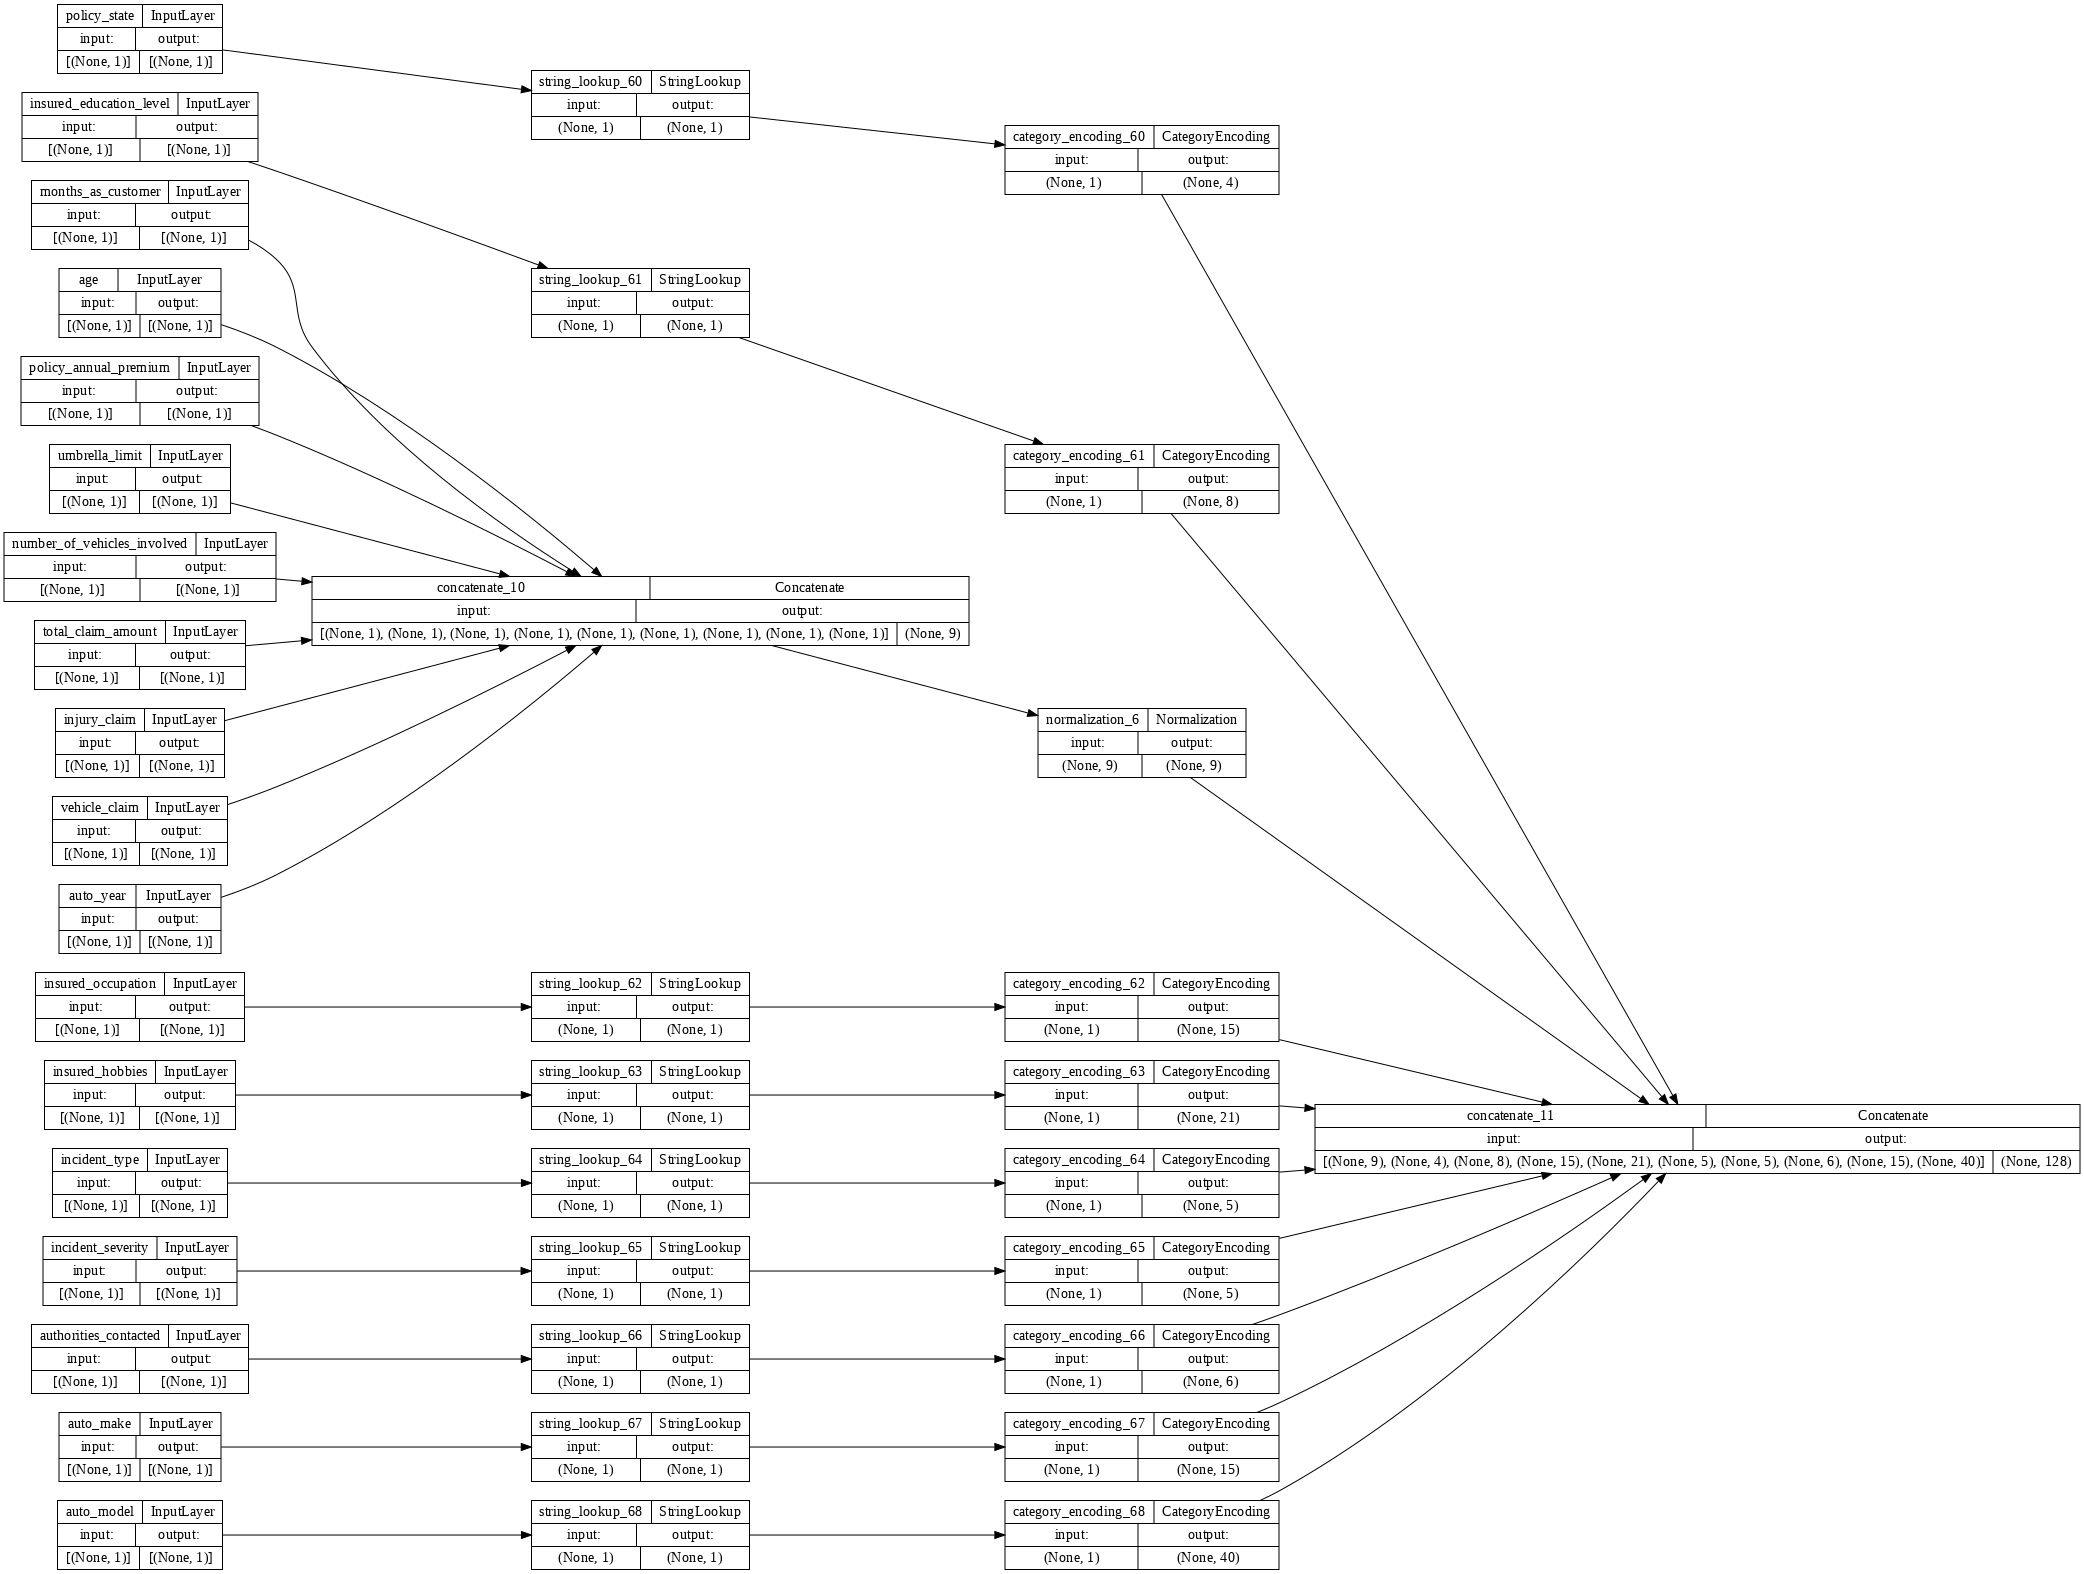

In [126]:
preprocessed_inputs_cat = layers.Concatenate()(preprocessed_inputs)

titanic_preprocessing = tf.keras.Model(inputs, preprocessed_inputs_cat)

tf.keras.utils.plot_model(model = titanic_preprocessing , rankdir="LR", dpi=72, show_shapes=True)

This model just contains the input preprocessing. You can run it to see what it does to your data. Keras models don't automatically convert pandas `DataFrame`s because it's not clear if it should be converted to one tensor or to a dictionary of tensors. So, convert it to a dictionary of tensors:

In [127]:
titanic_features_dict = {name: np.array(value) 
                         for name, value in titanic_features.items()}

Slice out the first training example and pass it to this preprocessing model, you see the numeric features and string one-hots all concatenated together:

In [128]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}
titanic_preprocessing(features_dict)

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[ 1.078,  0.991,  0.617, -0.479, -0.824,  0.714, -0.189,  0.75 ,
        -0.183,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  1.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         1.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  1.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,  0.   ,
         0.   

Now, build the model on top of this:

In [166]:
def titanic_model(preprocessing_head, inputs):
  body = tf.keras.Sequential([
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(1, activation='sigmoid')
  ])

  preprocessed_inputs = preprocessing_head(inputs)
  result = body(preprocessed_inputs)
  model = tf.keras.Model(inputs, result)

  model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer=tf.keras.optimizers.Adam(), metrics=['Accuracy','Precision','Recall'])
  return model

titanic_model = titanic_model(titanic_preprocessing, inputs)

When you train the model, pass the dictionary of features as `x`, and the label as `y`.

In [165]:
titanic_model.fit(x=titanic_features_dict, y=titanic_labels, batch_size = 25, epochs=100)

Epoch 1/100
32/32 [==============================] - 2s 4ms/step - loss: 0.5704 - Accuracy: 0.7290 - precision: 0.3378 - recall: 0.1012
Epoch 2/100
32/32 [==============================] - 0s 4ms/step - loss: 0.4891 - Accuracy: 0.7560 - precision: 0.7143 - recall: 0.0202
Epoch 3/100
32/32 [==============================] - 0s 5ms/step - loss: 0.4395 - Accuracy: 0.7880 - precision: 0.6882 - recall: 0.2591
Epoch 4/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3870 - Accuracy: 0.8250 - precision: 0.7368 - recall: 0.4534
Epoch 5/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3538 - Accuracy: 0.8430 - precision: 0.7184 - recall: 0.5992
Epoch 6/100
32/32 [==============================] - 0s 4ms/step - loss: 0.3317 - Accuracy: 0.8560 - precision: 0.7562 - recall: 0.6154
Epoch 7/100
32/32 [==============================] - 0s 4ms/step - loss: 0.2875 - Accuracy: 0.8910 - precision: 0.8026 - recall: 0.7409
Epoch 8/100
32/32 [=============================

Since the preprocessing is part of the model, you can save the model and reload it somewhere else and get identical results:

In [131]:
titanic_model.save('test')
reloaded = tf.keras.models.load_model('test')

In [132]:
features_dict = {name:values[:1] for name, values in titanic_features_dict.items()}

before = titanic_model(features_dict)
after = reloaded(features_dict)
assert (before-after)<1e-3
print(before)
print(after)

tf.Tensor([[0.316]], shape=(1, 1), dtype=float32)
tf.Tensor([[0.316]], shape=(1, 1), dtype=float32)


## Using tf.data


In the previous section you relied on the model's built-in data shuffling and batching while training the model.

If you need more control over the input data pipeline or need to use data that doesn't easily fit into memory: use `tf.data`.

For more examples, refer to the [`tf.data`: Build TensorFlow input pipelines](../../guide/data.ipynb) guide.

### On in memory data

As a first example of applying `tf.data` to CSV data, consider the following code to manually slice up the dictionary of features from the previous section. For each index, it takes that index for each feature:


In [70]:
import itertools

def slices(features):
  for i in itertools.count():
    # For each feature take index `i`
    example = {name:values[i] for name, values in features.items()}
    yield example

Run this and print the first example:

In [71]:
for example in slices(titanic_features_dict):
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

months_as_customer : 328
age                : 48
policy_number      : 521585
policy_bind_date   : 2014-10-17
policy_state       : OH
policy_csl         : 250/500
policy_deductable  : 1000
policy_annual_premium: 1406.91
umbrella_limit     : 0
insured_zip        : 466132
insured_sex        : MALE
insured_education_level: MD
insured_occupation : craft-repair
insured_hobbies    : sleeping
insured_relationship: husband
capital-gains      : 53300
capital-loss       : 0
incident_date      : 2015-01-25
incident_type      : Single Vehicle Collision
collision_type     : Side Collision
incident_severity  : Major Damage
authorities_contacted: Police
incident_state     : SC
incident_city      : Columbus
incident_location  : 9935 4th Drive
incident_hour_of_the_day: 5
number_of_vehicles_involved: 1
property_damage    : 1ES
bodily_injuries    : 1
witnesses          : 2
police_report_available: 1ES
total_claim_amount : 71610
injury_claim       : 6510
property_claim     : 13020
vehicle_claim      : 5208

The most basic `tf.data.Dataset` in memory data loader is the `Dataset.from_tensor_slices` constructor. This returns a `tf.data.Dataset` that implements a generalized version of the above `slices` function, in TensorFlow.

In [72]:
features_ds = tf.data.Dataset.from_tensor_slices(titanic_features_dict)

You can iterate over a `tf.data.Dataset` like any other python iterable:

In [73]:
for example in features_ds:
  for name, value in example.items():
    print(f"{name:19s}: {value}")
  break

months_as_customer : 328
age                : 48
policy_number      : 521585
policy_bind_date   : b'2014-10-17'
policy_state       : b'OH'
policy_csl         : b'250/500'
policy_deductable  : 1000
policy_annual_premium: 1406.91
umbrella_limit     : 0
insured_zip        : 466132
insured_sex        : b'MALE'
insured_education_level: b'MD'
insured_occupation : b'craft-repair'
insured_hobbies    : b'sleeping'
insured_relationship: b'husband'
capital-gains      : 53300
capital-loss       : 0
incident_date      : b'2015-01-25'
incident_type      : b'Single Vehicle Collision'
collision_type     : b'Side Collision'
incident_severity  : b'Major Damage'
authorities_contacted: b'Police'
incident_state     : b'SC'
incident_city      : b'Columbus'
incident_location  : b'9935 4th Drive'
incident_hour_of_the_day: 5
number_of_vehicles_involved: 1
property_damage    : b'1ES'
bodily_injuries    : 1
witnesses          : 2
police_report_available: b'1ES'
total_claim_amount : 71610
injury_claim       : 651

The `from_tensor_slices` function can handle any structure of nested dictionaries or tuples. The following code makes a dataset of `(features_dict, labels)` pairs:

In [74]:
titanic_ds = tf.data.Dataset.from_tensor_slices((titanic_features_dict, titanic_labels))

To train a model using this `Dataset`, you'll need to at least `shuffle` and `batch` the data.

In [75]:
titanic_batches = titanic_ds.shuffle(len(titanic_labels)).batch(32)

Instead of passing `features` and `labels` to `Model.fit`, you pass the dataset:

In [76]:
titanic_model.fit(titanic_batches, epochs=5)

Epoch 1/5
32/32 [==============================] - 2s 9ms/step - loss: nan
Epoch 2/5
32/32 [==============================] - 0s 8ms/step - loss: nan
Epoch 3/5
32/32 [==============================] - 0s 7ms/step - loss: nan
Epoch 4/5
32/32 [==============================] - 0s 7ms/step - loss: nan
Epoch 5/5
32/32 [==============================] - 0s 6ms/step - loss: nan


### From a single file

So far this tutorial has worked with in-memory data. `tf.data` is a highly scalable toolkit for building data pipelines, and provides a few functions for dealing loading CSV files. 

Now read the CSV data from the file and create a `tf.data.Dataset`.

(For the full documentation, see `tf.data.experimental.make_csv_dataset`)


In [48]:
titanic_csv_ds = tf.data.experimental.make_csv_dataset(
    "/content/sample_data/insurance_claims.csv",
    batch_size=5, # Artificially small to make examples easier to show.
    label_name='fraud_reported',
    num_epochs=1,
    ignore_errors=True,)

This function includes many convenient features, so the data is easy to work with. This includes:

* Using the column headers as dictionary keys.
* Automatically determining the type of each column.

Caution: Make sure to set the `num_epochs` argument in `tf.data.experimental.make_csv_dataset`, otherwise the default behavior for `tf.data.Dataset` is to loop endlessly.

In [49]:
for batch, label in titanic_csv_ds.take(1):
  for key, value in batch.items():
    print(f"{key:20s}: {value}")
  print()
  print(f"{'label':20s}: {label}")

months_as_customer  : [163  38 101 146 153]
age                 : [36 28 27 31 37]
policy_number       : [974522 970607 557218 411289 627486]
policy_bind_date    : [b'2000-01-27' b'1995-03-28' b'1997-11-23' b'1997-09-16' b'2005-11-10']
policy_state        : [b'I0' b'OH' b'IL' b'OH' b'I0']
policy_csl          : [b'250/500' b'250/500' b'500/1000' b'250/500' b'500/1000']
policy_deductable   : [1000 1000  500 2000  500]
policy_annual_premium: [1503.21 1019.44  982.7  1082.72 1010.77]
umbrella_limit      : [      0       0 6000000       0       0]
insured_zip         : [448190 437387 440865 478661 438215]
insured_sex         : [b'MALE' b'MALE' b'FEMALE' b'FEMALE' b'MALE']
insured_education_level: [b'MD' b'Masters' b'College' b'PhD' b'High School']
insured_occupation  : [b'other-service' b'transport-moving' b'transport-moving'
 b'machine-op-inspct' b'transport-moving']
insured_hobbies     : [b'cross-fit' b'yachting' b'video-games' b'video-games' b'basketball']
insured_relationship: [b'husban

Note: If you run the above cell twice it will produce different results. The default settings for `tf.data.experimental.make_csv_dataset` include `shuffle_buffer_size=1000`, which is more than sufficient for this small dataset, but may not be for a real-world dataset.

It can also decompress the data on the fly. Here's a gzipped CSV file containing the [metro interstate traffic dataset](https://archive.ics.uci.edu/ml/datasets/Metro+Interstate+Traffic+Volume).

![A traffic jam.](https://github.com/tensorflow/docs/blob/master/site/en/tutorials/load_data/images/csv/traffic.jpg?raw=1)

Image [from Wikimedia](https://commons.wikimedia.org/wiki/File:Trafficjam.jpg)
